In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
from __future__ import print_function
import numpy as np
import statsmodels.api as sm
from scipy import stats
import tensorflow as tf
from scipy.special import factorial

In [2]:
files = ["data_1_1.csv", "data_1_2.csv", "data_1_3.csv", "data_1_4.csv", "data_1_5.csv"]

In [3]:
df = pd.read_csv(files[0])

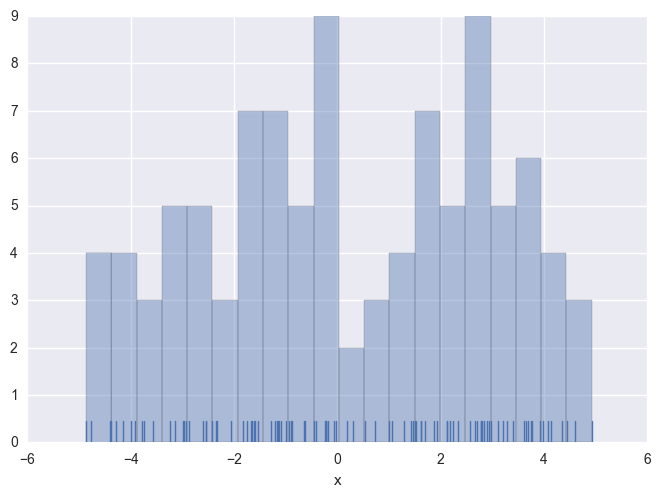

In [6]:
sns.distplot(df['x'], bins=20, kde=False, rug=True)

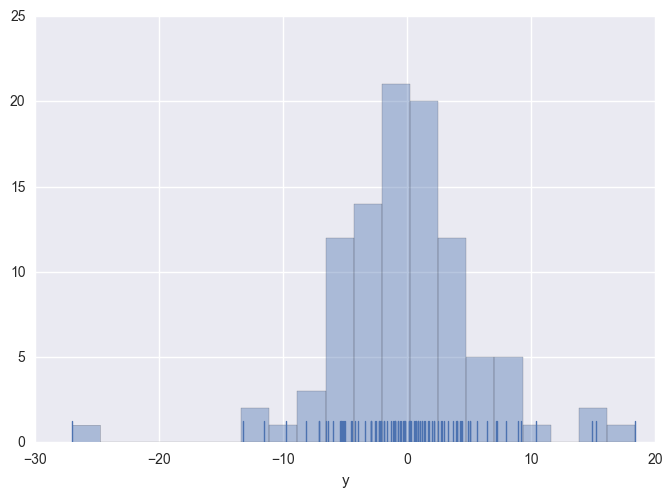

In [8]:
sns.distplot(df['y'], bins=20, kde=False, rug=True)

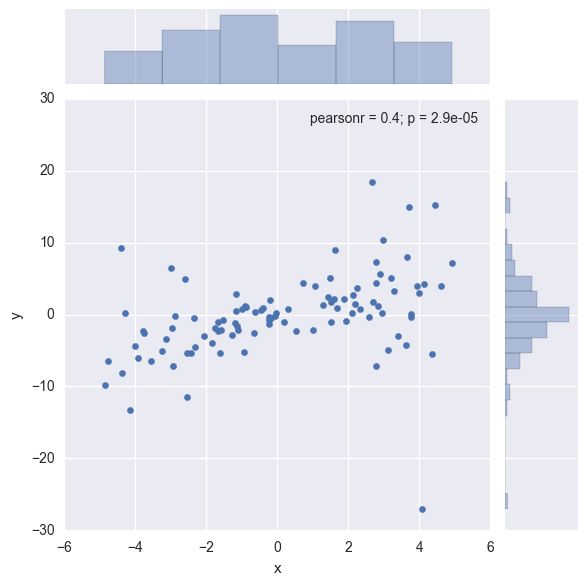

In [9]:
sns.jointplot(x="x", y="y", data=df)

In [4]:
# Exogenous regressor variable
exog = df['x'].as_matrix()
exog = np.resize(exog, (exog.shape[0], 1))
# Endogenous response variable
endo = df['y'].as_matrix()
endo = np.resize(endo, (endo.shape[0], 1))

In [5]:
# Set logging
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('glm')

In [ ]:
def train_glm_np(exog, endo, opts):
    
    # Input data.
    batch_size = exog.shape[0]
    logger.debug("batch_size is {}".format(batch_size))
    ones = np.ones((batch_size, 1), dtype=np.float32)
    scalar_one = np.ones((1, 1), dtype=np.float32)
    
    x = np.concatenate((exog, ones), axis=1)
    logger.info("shape of [X] is {}".format(x.shape))
    logger.debug("[X] is {}".format(x))
    
    Y = endo
    logger.info("shape of [Y] is {}".format(Y.shape))
    logger.debug("[Y] is {}".format(Y))
    
    init_b = np.array([[0.18, 0.19]], dtype=np.float32)
    logger.debug("[b] is {}".format(init_b))
    
    def U_I(b):
        
        n = np.matmul(x, np.transpose(b))
        logger.debug("[n] is {}".format(n))

        dn_db = x
        logger.debug("[dn_db] is {}".format(dn_db))

        # Set link function
        mu = np.exp(n)
        logger.debug("[mu] is {}".format(mu))

        dmu_dn = np.exp(n)
        logger.debug("[dmu_dn] is {}".format(dmu_dn))

        # Set theta as a function of mu
        theta = np.log(mu)
        logger.debug("[theta] is {}".format(theta))

        # Set the variance as a function of mu        
        a_phi = scalar_one
        dispersion = scalar_one
        var_mu = 1.0*mu

        # Calculate U 
        U = np.add.reduce(\
                          np.subtract(Y, mu)*\
                          np.divide(scalar_one, a_phi)*\
                          np.divide(ones, var_mu)*\
                          dmu_dn*\
                          dn_db, 0)
        logger.debug("shape of [U] is {}".format(U.shape))
        logger.debug("[U] is {}".format(U))

        # Calculate I
        I = np.add.reduce(dn_db*\
                          np.divide(scalar_one, a_phi)*\
                          np.divide(ones, var_mu)*\
                          dmu_dn*\
                          dn_db, 0)
        logger.debug("shape of [I] is {}".format(I.shape))
        logger.debug("[I] is {}".format(I))
        
        return (U, I)
    
    def b_delta(U, I):
        b_delta = opts.learning_rate*(I*U)
        logger.debug("shape of [b_delta] is {}".format(b_delta.shape))
        logger.debug("[b_delta] is {}".format(b_delta))
        return b_delta
    
    def training_op(U, I, b):
        delta = b_delta(U, I)
        return np.copy(delta)
    
    def loss(U):
        return np.add.reduce(U) 

    logger.info("Initialized")
    
    b = init_b
    
    for step in range(1, opts.epochs_to_train + 1):
        U, I = U_I(b)
        delta = training_op(U, I, b)
        b = b + delta
        curr_loss = loss(U)
        
        if step%10==0:
            logger.info("Loss is {}".format(curr_loss))
            logger.info("b is {} at step {}".format(b, step))
            logger.info("b_delta was {} at step {}".format(delta, step))
            logger.info("U was {} at step {}".format(U, step))
            logger.info("I was {} at step {}".format(I, step))
            
        if curr_loss < 0 or abs(curr_loss) < opts.tolerance or step > opts.epochs_to_train:
            logger.info("early stopping: loss is {} less than tolerance {} at step {}".format(curr_loss, opts.tolerance, step))
            break

    return b

In [10]:
(-2.34*0.18)+0.19

-0.23119999999999996

In [ ]:
train_glm_np(exog, endo, Options())

In [57]:
# Set logging
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('glm')
PRINT_LIMIT = 5

def train_glm(exog, endo, opts):
    
    graph = tf.Graph()
    
    with graph.as_default():
        
        # Variables and constant op for data storage
        b = tf.Variable([[0.18, 0.18]], dtype=tf.float32)
        
        # Constant tensor of ones
        ones = tf.constant(1.0, dtype=tf.float32, shape=[opts.batch_size, 1]) 
        scalar_one = tf.constant(1.0, dtype=tf.float32)

        # Placeholders for training input or predictor variable
        train_input = tf.placeholder(tf.float32, shape=[opts.batch_size])
        x = tf.concat(1, [tf.reshape(train_input, shape=[opts.batch_size, 1]), ones])
        
        # Placeholders for training output or response variable
        train_output = tf.placeholder(tf.float32, shape=[opts.batch_size])
        Y = tf.reshape(train_output, shape=[opts.batch_size, 1])
        
        logger.info(x.get_shape())
        logger.info(b.get_shape())
        
        # linear function
        n = tf.matmul(x, tf.transpose(b))
        
        # derived tensors
        dn_db = x
        
        # inverse link function on n
        mu = tf.exp(n)
        # derivative of inverse link function on n
        dmu_dn = tf.exp(n)
        
        # Error Distribution Tensors
        a_phi = scalar_one
        dispersion = scalar_one

        # theta as a function of mu
        theta = tf.log(mu)
        
        # variance as a function of mu        
        var_mu = mu
        
        # log likelihood of the training set
        U = tf.reduce_sum(tf.sub(Y, mu)*tf.div(scalar_one, a_phi)*tf.div(ones, var_mu)*dmu_dn*dn_db, 0)
        # reduced sum of the information matrix
        I = tf.reduce_sum(x*tf.div(ones, tf.exp(n))*tf.exp(n)*x, 0)

        # update to the b vector
        b_delta = tf.reshape(tf.mul(tf.mul(opts.learning_rate, tf.inv(I)), U), shape=[1, 2])
        new_b = tf.add(b, b_delta)
        training_op = tf.assign_add(b, new_b)
        
        
        loss = tf.reduce_sum(U)
        tf.scalar_summary('loss', loss)
        tf.add_to_collection(tf.GraphKeys.TRAINABLE_VARIABLES, b)

        # Summary Writer
        summary_ops = tf.merge_all_summaries()
        summary_writer = tf.train.SummaryWriter("log/", graph)
        # Add variable initializer.
        init = tf.initialize_all_variables()
        feed_dict = {train_input: exog, train_output: endo}
        
        with tf.Session(graph=graph) as session:
            
            init.run()
            logger.info("Initialized")
            
            def _eval(tensor, row_limit=PRINT_LIMIT):
                shape = tensor.get_shape()
                tensor_eval = session.run([tensor], feed_dict=feed_dict)[0]
                if(len(shape)==0):
                    return tensor_eval
                elif(len(shape)==1):
                    return tensor_eval[:row_limit]
                elif(len(shape)==2):
                    return tensor_eval[:row_limit, :]
                else:
                    return None
            
            logger.info("U is {} at step 0".format(_eval(U)))
            logger.info("I is {} at step 0".format(_eval(I)))
            logger.info("b is {} at step 0".format(_eval(b)))
            logger.info("b_delta is {} at step 0".format(_eval(b_delta)))
            
            for step in range(1, opts.epochs_to_train + 1):
                _, loss_val, U_val, I_val, b_val, b_delta_val, summary = session.run([training_op, loss, U, I, b, b_delta, summary_ops], feed_dict=feed_dict)
                
                summary_writer.add_summary(summary, step)
                if step%1000==0 or step==1:
                    logger.info("loss is {} at step {}".format(loss_val, step))
                    logger.info("b is {} at step {}".format(b_val, step))
                    logger.info("b_delta is {} at step {}".format(b_delta_val, step))
                    logger.info("U is {} at step {}".format(U_val, step))
                    logger.info("I is {} at step {}".format(I_val, step))
#                 if loss_val < 0 or abs(loss_val) < opts.tolerance or step > opts.epochs_to_train:
#                     logger.info("early stopping: loss is {} less than tolerance {} at step {}".format(loss_val, opts.tolerance, step))
#                     break

            return _eval(b)

In [8]:
class Options(object):
    """Options used by model."""

    def __init__(self):
        # Model options.

        self.input_dim = 1

        self.output_dim = 1

        # The initial learning rate.
        self.learning_rate = 0.01

        # Number of examples for one training step.
        self.batch_size = 100

        # Maximum Epochs
        self.epochs_to_train = 10000

        # Early Stop
        self.tolerance = 1e-5

In [58]:
opts = Options()
train_glm(exog, endo, opts)

INFO:glm:(100, 2)
INFO:glm:(1, 2)
INFO:glm:Initialized
INFO:glm:U is [ 431.9727478  -149.37057495] at step 0
INFO:glm:I is [ 712.04101562  100.        ] at step 0
INFO:glm:b is [[ 0.18000001  0.18000001]] at step 0
INFO:glm:b_delta is [[ 0.00606668 -0.01493706]] at step 0
INFO:glm:loss is 282.602172852 at step 1
INFO:glm:b is [[ 0.36606669  0.34506297]] at step 1
INFO:glm:b_delta is [[ 0.00606668 -0.01493706]] at step 1
INFO:glm:U is [ 431.9727478  -149.37057495] at step 1
INFO:glm:I is [ 712.04101562  100.        ] at step 1
INFO:glm:loss is nan at step 1000
INFO:glm:b is [[ nan  nan]] at step 1000
INFO:glm:b_delta is [[ nan  nan]] at step 1000
INFO:glm:U is [ nan  nan] at step 1000
INFO:glm:I is [ nan  nan] at step 1000
INFO:glm:loss is nan at step 2000
INFO:glm:b is [[ nan  nan]] at step 2000
INFO:glm:b_delta is [[ nan  nan]] at step 2000
INFO:glm:U is [ nan  nan] at step 2000
INFO:glm:I is [ nan  nan] at step 2000
INFO:glm:loss is nan at step 3000
INFO:glm:b is [[ nan  nan]] at ste

KeyboardInterrupt: 

In [47]:
from tensorflow.contrib.learn.python import learn
from sklearn import linear_model

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
x = np.resize(endo, [100, 1])
Y = np.resize(exog, [100, 1])
regr.fit(x, Y)

# The coefficients
print('Coefficients: \n', regr.coef_)

# The intercept
print('Intercept: \n', regr.intercept_)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(x) - Y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, Y))

Coefficients: 
 [[ 0.18617697]]
Intercept: 
 [ 0.19938353]
Mean squared error: 5.93
Variance score: 0.16


In [30]:
glm_poisson = sm.GLM(endo, exog, family=sm.families.Poisson())

In [31]:
residuals = glm_poisson.fit()

In [32]:
print(residuals.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       99
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -52.594
Date:                Mon, 24 Oct 2016   Deviance:                       14939.
Time:                        11:29:05   Pearson chi2:                 7.20e+03
No. Iterations:                     7                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.4903      0.020     24.076      0.000         0.450     0.530


In [45]:
nobs = residuals.nobs
y = endog #/endog.sum()
yhat = residuals.mu

In [37]:
from statsmodels.graphics.api import abline_plot

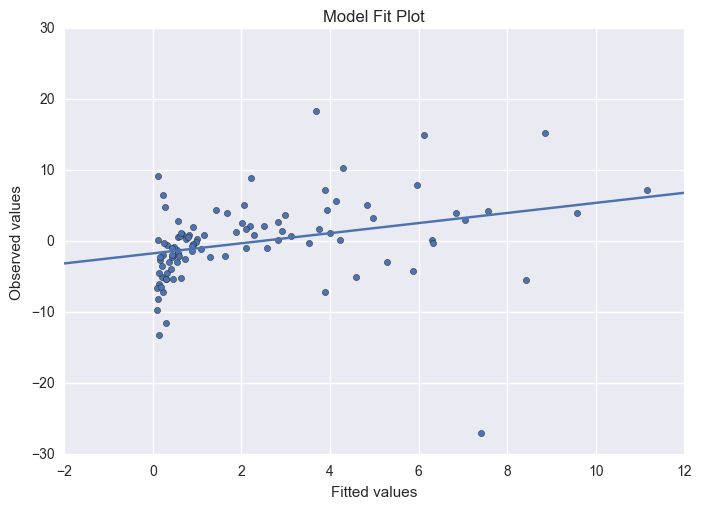

In [46]:
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values')

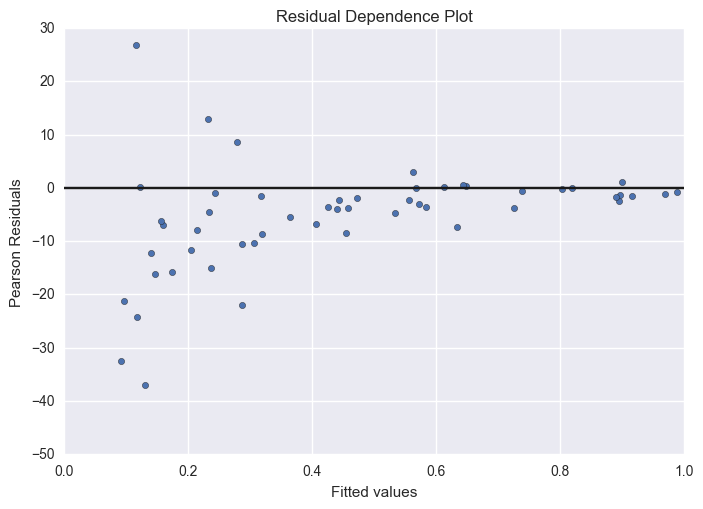

In [40]:
fig, ax = plt.subplots()

ax.scatter(yhat, residuals.resid_pearson)
ax.hlines(0, 0, 1)
ax.set_xlim(0, 1)
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

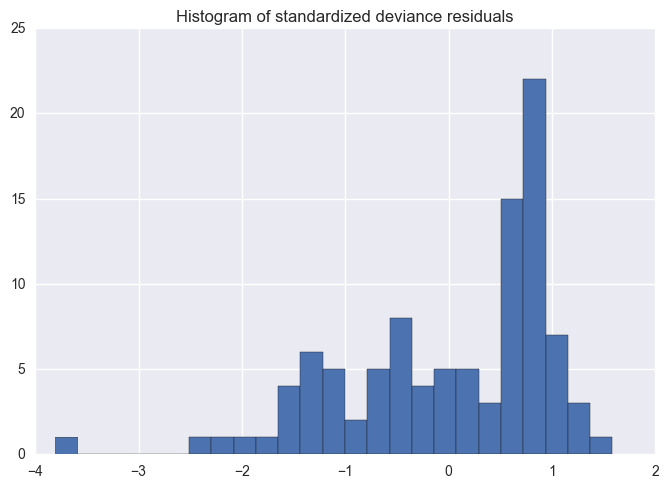

In [42]:
from scipy import stats

fig, ax = plt.subplots()

resid = residuals.resid_deviance.copy()
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=25)
ax.set_title('Histogram of standardized deviance residuals');

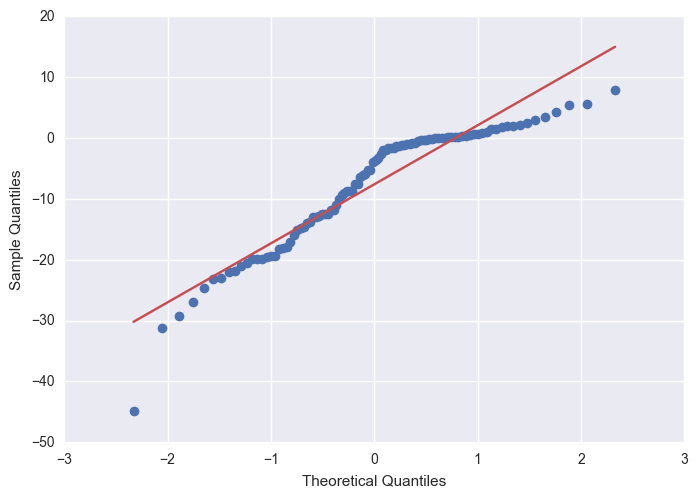

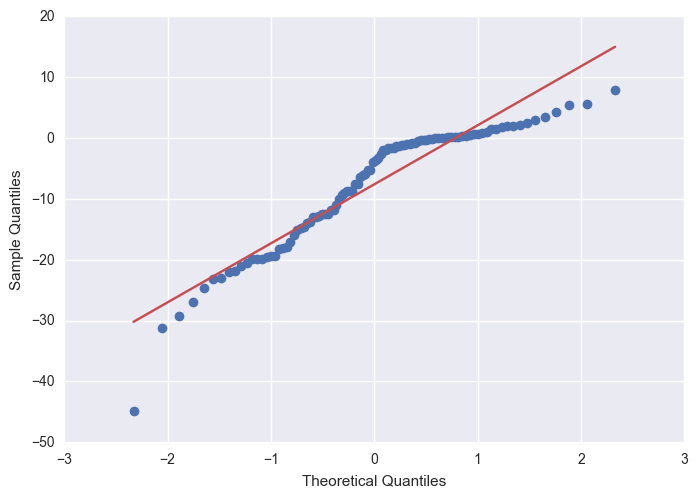

In [44]:
from statsmodels import graphics
graphics.gofplots.qqplot(resid, line='r')